In [2]:
pip install ibm-watson


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.8/342.8 kB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.3 MB/s eta 0:00:00
  Created wheel for ibm-watson: filename=ibm_watson-9.0.0-py3-none-any.whl size=345070 sha256=a9f4ab2862899db7e14c733f442e17ecf838ffbd59d53d3e9fe6880585f582e6
  Stored in directory: /root/.cache/pip/wheels/a1/ed/65/5abe3aa86c063331a8064910b7722d22ddf0bd75fc322f6c48
Successfully built ibm-watson


In [3]:
from ibm_watson_machine_learning import APIClient
import ibm_boto3
from ibm_botocore.client import Config
import pandas as pd

import requests
from requests.auth import HTTPBasicAuth

In [4]:
# Watson Machine Learning credentials (dari WML instance)
wml_credentials = {
    "apikey": "mNT2Ji-R2fNFl9o2ST14UBWbgBC00NcKLPI8cjpL-QEF",  # ini API key WML-mu
    "url": "https://jp-tok.ml.cloud.ibm.com"
}

# Cloud Object Storage credentials (dari COS credential my-cos-credential)
cos_credentials = {
    "apikey": "WJUmIV6QBCX8OSjyZ7z2hxk8-IMkhzSEUTkZFyFsN6D1",  # ini API key COS-mu
    "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/cc7114bd7803461fbaf23d05deef71b5:64d2b6f9-dc4d-4a2a-bf43-179346fa4c46::",
    "endpoint": "https://s3.jp-tok.cloud-object-storage.appdomain.cloud",
    "bucket_name": "bucket-60yud9wn7bx7dn4"
}

# Initialize Watson Machine Learning client
from ibm_watson_machine_learning import APIClient
client = APIClient(wml_credentials)


In [5]:
cos_credentials = {
    "apikey": "WJUmIV6QBCX8OSjyZ7z2hxk8-IMkhzSEUTkZFyFsN6D1",  # ini pakai API key dari COS, bukan WML
    "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/cc7114bd7803461fbaf23d05deef71b5:64d2b6f9-dc4d-4a2a-bf43-179346fa4c46::",
    "endpoint": "https://s3.jp-tok.cloud-object-storage.appdomain.cloud",
    "bucket_name": "bucket-60yud9wn7bx7dn4"
}


In [6]:
cos = ibm_boto3.client('s3',
    ibm_api_key_id=cos_credentials['apikey'],
    ibm_service_instance_id=cos_credentials['resource_instance_id'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credentials['endpoint']
)


In [7]:
spaces = client.spaces.list()
print(spaces)


Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  --------------  ------------------------
ID                                    NAME            CREATED
af6d36df-105c-4c1e-b528-d108ba95ba44  ProjectDeploy1  2025-05-30T18:15:08.761Z
------------------------------------  --------------  ------------------------
                                     ID            NAME  \
0  af6d36df-105c-4c1e-b528-d108ba95ba44  ProjectDeploy1   

                    CREATED  
0  2025-05-30T18:15:08.761Z  


In [8]:
space_id = "af6d36df-105c-4c1e-b528-d108ba95ba44"
client.set.default_space(space_id)


'SUCCESS'

In [9]:
from google.colab import files
uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


In [11]:
import pandas as pd

# Baca file CSV
df = pd.read_csv('Tweets.csv')

# Cek isi awal data
print(df.head())


             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

In [12]:
# Misalnya kolomnya bernama 'text'
teks_tweet = df['text'].tolist()


In [16]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions

# Ganti dengan API Key & URL Watson NLU-mu
nlu_apikey = 'oUNT-XxJ3kIvGaDisQyyft8xuXU9OduBQTyAsKyKnqS_'
nlu_url = 'https://api.jp-tok.natural-language-understanding.watson.cloud.ibm.com/instances/d7b2008c-a352-4374-8963-25874688f23e'

# Setup autentikasi
authenticator = IAMAuthenticator(nlu_apikey)
nlu = NaturalLanguageUnderstandingV1(
    version='2022-04-07',
    authenticator=authenticator
)
nlu.set_service_url(nlu_url)


In [26]:
df = pd.read_csv('Tweets.csv')
teks_tweet = [t for t in df['text'].tolist() if isinstance(t, str) and len(t.strip()) > 3]


In [27]:
import re

def preprocess_teks(teks):
    teks = teks.strip()
    teks = re.sub(r"http\S+", "", teks)  # hapus URL
    teks = re.sub(r"@\w+", "", teks)     # hapus mention
    teks = re.sub(r"[^a-zA-Z0-9\s]", "", teks)  # hapus tanda baca
    teks = re.sub(r"\s+", " ", teks)    # hilangkan spasi ganda
    return teks

teks_tweet = [preprocess_teks(t) for t in teks_tweet if len(preprocess_teks(t)) > 3]


In [29]:
teks_tweet = [t for t in teks_tweet if isinstance(t, str) and len(t.strip()) >= 10]


In [30]:
teks_tweet = [preprocess_teks(t) for t in teks_tweet]
teks_tweet = [t for t in teks_tweet if len(t) >= 10]


In [33]:
import re

def valid_text(teks):
    # Cek teks minimal 10 karakter dan ada minimal 1 kata berisi huruf
    if len(teks.strip()) < 10:
        return False
    # Cek ada huruf (a-z atau A-Z)
    if not re.search(r'[a-zA-Z]', teks):
        return False
    return True

teks_tweet = [t for t in teks_tweet if valid_text(t)]


In [36]:
import re

def preprocess(teks):
    teks = re.sub(r'http\S+', '', teks)
    teks = re.sub(r'@\w+', '', teks)
    teks = re.sub(r'#\w+', '', teks)
    return teks.strip()

def valid_text(teks):
    if len(teks) < 20:
        return False
    if len(teks.split()) < 5:
        return False
    if not re.search(r'[a-zA-Z]', teks):
        return False
    return True

teks_tweet_clean = [preprocess(t) for t in teks_tweet]
teks_tweet_clean = [t for t in teks_tweet_clean if valid_text(t)]


In [41]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 25.2 MB/s eta 0:00:00


In [42]:
import pandas as pd
import emoji
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

# Watson NLU setup
nlu_apikey = 'oUNT-XxJ3kIvGaDisQyyft8xuXU9OduBQTyAsKyKnqS_'
nlu_url = 'https://api.jp-tok.natural-language-understanding.watson.cloud.ibm.com/instances/d7b2008c-a352-4374-8963-25874688f23e'

authenticator = IAMAuthenticator(nlu_apikey)
nlu = NaturalLanguageUnderstandingV1(
    version='2022-04-07',
    authenticator=authenticator
)
nlu.set_service_url(nlu_url)

# Preprocessing functions
def remove_nonascii(teks):
    return teks.encode('ascii', 'ignore').decode('ascii')

def remove_emoji(teks):
    return emoji.replace_emoji(teks, replace='')

def clean_text(teks):
    teks = remove_nonascii(teks)
    teks = remove_emoji(teks)
    return teks.strip()

# Load data
df = pd.read_csv('Tweets.csv')
teks_tweet = [t for t in df['text'].tolist() if isinstance(t, str)]

hasil_sentimen = []

for teks in teks_tweet:
    teks_clean = clean_text(teks)

    # Skip kalau terlalu pendek (misal < 10 karakter)
    if len(teks_clean) < 10:
        print(f"⏩ Skip teks pendek: '{teks_clean}'")
        continue

    try:
        response = nlu.analyze(
            text=teks_clean,
            features=Features(sentiment=SentimentOptions()),
            language='en'  # Tentukan bahasa eksplisit
        ).get_result()

        skor = response['sentiment']['document']['score']
        label = response['sentiment']['document']['label']

        print(f"✅ Berhasil: '{teks_clean[:30]}...' → {label}, skor: {skor}")
    except Exception as e:
        print(f"❌ Gagal analisis teks: '{teks_clean[:30]}...', error: {e}")
        skor = None
        label = 'error'

    hasil_sentimen.append({'teks': teks_clean, 'skor': skor, 'label': label})

# Simpan hasil ke DataFrame
df_hasil = pd.DataFrame(hasil_sentimen)

# Lihat hasil
print("\n📊 Hasil Sentimen:")
print(df_hasil.head())

# (Opsional) Simpan ke file CSV
df_hasil.to_csv('hasil_sentimen.csv', index=False)
print("\n✅ Hasil disimpan ke 'hasil_sentimen.csv'")


Streaming output truncated to the last 5000 lines.
✅ Berhasil: '@USAirways denied me standby b...' → negative, skor: -0.981143
✅ Berhasil: '@USAirways you reminded me tod...' → negative, skor: -0.484368
✅ Berhasil: '@USAirways looks like our bag ...' → positive, skor: 0.830369
✅ Berhasil: '@USAirways .... I've been tryi...' → negative, skor: -0.902764
✅ Berhasil: '@USAirways you are the worst....' → negative, skor: -0.936742
✅ Berhasil: '@USAirways making folks run fr...' → negative, skor: -0.945881
✅ Berhasil: '@USAirways have been waiting i...' → negative, skor: -0.939583
✅ Berhasil: '@USAirways not given option fo...' → negative, skor: -0.899894
✅ Berhasil: '@USAirways doesn't let u do st...' → negative, skor: -0.914334
✅ Berhasil: '@USAirways and @AmericanAir ar...' → negative, skor: -0.737836
✅ Berhasil: '@USAirways absolutely worst ex...' → negative, skor: -0.955376
✅ Berhasil: '@USAirways @AmericanAir as soo...' → negative, skor: -0.92261
✅ Berhasil: '@USAirways @AmericanAir hav

In [43]:
pip install matplotlib seaborn wordcloud


Jumlah tweet per sentimen:
label
negative    8661
positive    3790
neutral     2188
Name: count, dtype: int64


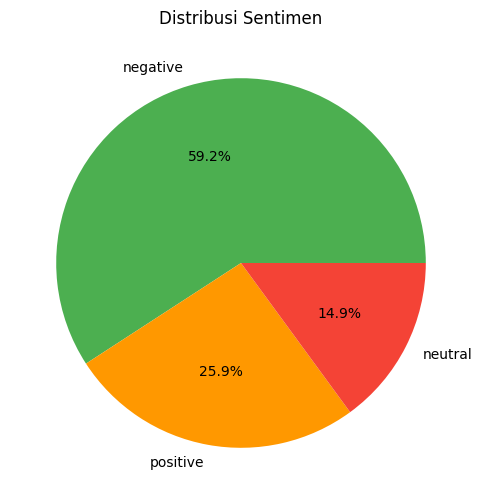

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('hasil_sentimen.csv')
df_clean = df[df['label'] != 'error']

sentimen_counts = df_clean['label'].value_counts()

# Tampilkan jumlah tweet per sentimen secara angka
print("Jumlah tweet per sentimen:")
print(sentimen_counts)

plt.figure(figsize=(6,6))
plt.pie(sentimen_counts, labels=sentimen_counts.index, autopct='%1.1f%%',
        colors=['#4CAF50', '#FF9800', '#F44336'])
plt.title('Distribusi Sentimen')
plt.show()


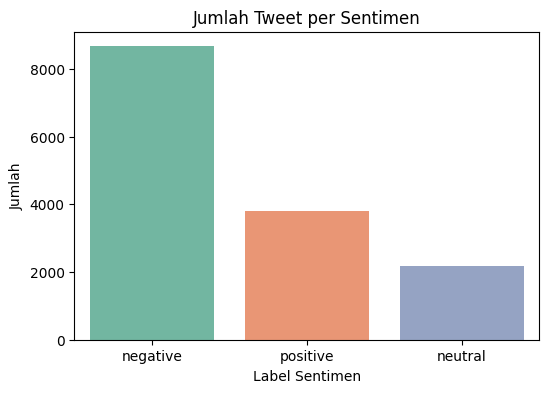

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('hasil_sentimen.csv')
df_clean = df[df['label'] != 'error']

sentimen_counts = df_clean['label'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette='Set2')
plt.title('Jumlah Tweet per Sentimen')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah')
plt.show()


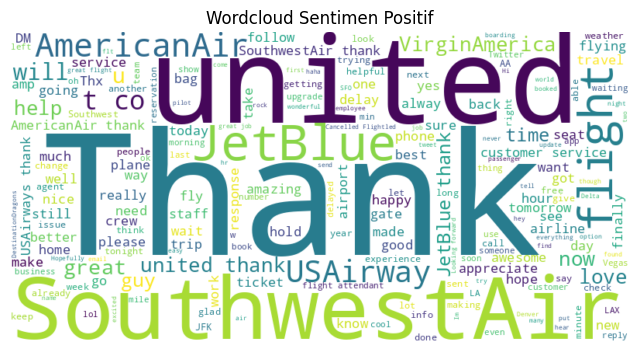

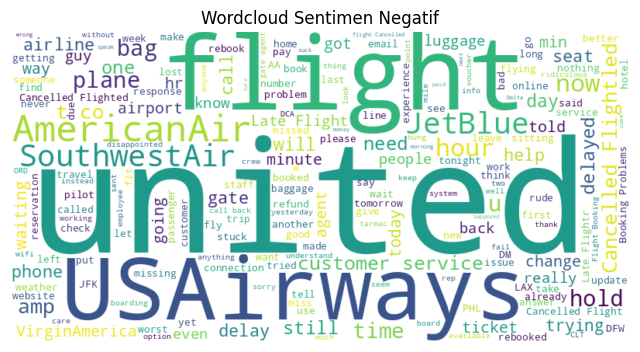

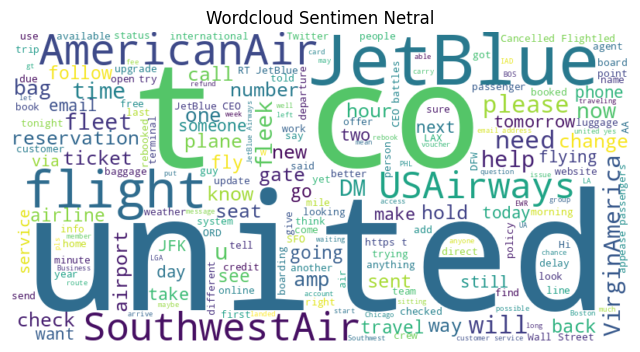

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df = pd.read_csv('hasil_sentimen.csv')
df_clean = df[df['label'] != 'error']

# Gabungkan teks per label
positif_teks = ' '.join(df_clean[df_clean['label'] == 'positive']['teks'].tolist())
negatif_teks = ' '.join(df_clean[df_clean['label'] == 'negative']['teks'].tolist())
netral_teks = ' '.join(df_clean[df_clean['label'] == 'neutral']['teks'].tolist())

# Wordcloud Positif
plt.figure(figsize=(8,6))
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positif_teks)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Sentimen Positif')
plt.show()

# Wordcloud Negatif
plt.figure(figsize=(8,6))
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(negatif_teks)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Sentimen Negatif')
plt.show()

# Wordcloud Netral
plt.figure(figsize=(8,6))
wc_neu = WordCloud(width=800, height=400, background_color='white').generate(netral_teks)
plt.imshow(wc_neu, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Sentimen Netral')
plt.show()
